In [ ]:
%pip install torchmetrics
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
import os
import random
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy
import torch.optim as optim
from tqdm import tqdm
import time
from torchinfo import summary


# Dataset

In [ ]:
# Load dataset
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
val_ratio = 0.1
generator = torch.Generator().manual_seed(seed)
use_reduced_data = True

transform = transforms.Compose([
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-30, 30)),
    # transforms.ColorJitter(),
    transforms.RandAugment(num_ops=2, magnitude=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

CIFAR10Dataset = torchvision.datasets.CIFAR10(root='.', download=True)
full_train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transformTest)

if use_reduced_data:
    total_reduced_size = 10000
    selected_indices = torch.randperm(len(full_train_dataset), generator=generator)[:total_reduced_size]
else:
    selected_indices = torch.arange(len(full_train_dataset))

val_size = int(len(selected_indices) * val_ratio)
train_size = len(selected_indices) - val_size
train_indices, val_indices = random_split(selected_indices, [train_size, val_size], generator=generator)


train_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transform),
    train_indices.indices
)

val_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transformTest),
    val_indices.indices
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

100%|██████████| 170M/170M [00:06<00:00, 27.5MB/s]


# Pretrain models

In [ ]:
import torch.nn as nn
from torchvision.models import resnet50, mobilenet_v3_large

def get_resnet50(num_classes=10):
    model = resnet50(pretrained=True)

    # Adjust first conv and maxpool for CIFAR-10 input size
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last half: layer3, layer4, and fc
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            param.requires_grad = True

    # Replace final classification layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_mobilenetv3(num_classes=10):
    model = mobilenet_v3_large(pretrained=True)

    # Adjust first conv stride for 32x32 input
    model.features[0][0].stride = (1, 1)

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last half of features (features[8:] since total 17 blocks) + classifier
    for i in range(8, len(model.features)):
        for param in model.features[i].parameters():
            param.requires_grad = True

    for param in model.classifier.parameters():
        param.requires_grad = True

    # Replace final classification layer
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model

In [ ]:
resnet50_model = get_resnet50()
summary(resnet50_model, (1, 3, 32, 32))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           (1,728)
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           (128)
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─Identity: 1-4                          [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 256, 32, 32]          --
│    └─Bottleneck: 2-1                   [1, 256, 32, 32]          --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]    

In [ ]:
mobilenet_model = get_mobilenetv3()
summary(mobilenet_model, (1, 3, 32, 32))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 155MB/s]


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 10]                   --
├─Sequential: 1-1                                  [1, 960, 2, 2]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                            [1, 16, 32, 32]           (432)
│    │    └─BatchNorm2d: 3-2                       [1, 16, 32, 32]           (32)
│    │    └─Hardswish: 3-3                         [1, 16, 32, 32]           --
│    └─InvertedResidual: 2-2                       [1, 16, 32, 32]           --
│    │    └─Sequential: 3-4                        [1, 16, 32, 32]           (464)
│    └─InvertedResidual: 2-3                       [1, 24, 16, 16]           --
│    │    └─Sequential: 3-5                        [1, 24, 16, 16]           (3,440)
│    └─InvertedResidual: 2-4                       [1, 24, 16, 16]           --
│    │    └─Sequential

# Train and Validation

In [ ]:
def train(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    model.to(device)
    results = []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        for inputs, labels in (train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_acc, val_loss = validation(model, val_loader, device, show_metrics=False)
        scheduler.step()
        # print(f'Learning Rate: {scheduler.get_last_lr()[-1]:0.4e}')
        print(f"Epoch {epoch+1}/{epochs}({time.time() - start_time:.2f}s)  - accuracy: {train_acc:.4f}  - loss: {train_loss:.4f}  - val_accuracy: {val_acc:.4f}  - val_loss: {val_loss:.4f}")
        results.append([train_acc, train_loss, val_acc, val_loss])
    return results

def validation(model, test_loader, device, show_metrics=True):
    metric = MulticlassAccuracy(num_classes=10).to(device)
    model.eval()
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in (test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            metric.update(outputs, labels)
            total_loss += loss.item()

    accuracy_val = metric.compute().item()
    avg_loss = total_loss / len(test_loader)

    if show_metrics:
        print(f"Validation Accuracy: {accuracy_val:.4f} Loss: {avg_loss:.4f}")
    return accuracy_val, avg_loss


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
learning_rate = 1e-3
resnet50_model.to(device)
history_resnet50 = train(resnet50_model, train_loader, val_loader, epochs, learning_rate, device)
validation(resnet50_model, test_loader, device)

Epoch 1/20(21.35s)  - accuracy: 0.3814  - loss: 1.8461  - val_accuracy: 0.5556  - val_loss: 1.5052
Epoch 2/20(19.40s)  - accuracy: 0.5099  - loss: 1.5840  - val_accuracy: 0.6028  - val_loss: 1.4446
Epoch 3/20(19.86s)  - accuracy: 0.5650  - loss: 1.4851  - val_accuracy: 0.6140  - val_loss: 1.3783
Epoch 4/20(20.98s)  - accuracy: 0.6081  - loss: 1.3889  - val_accuracy: 0.6035  - val_loss: 1.4113
Epoch 5/20(21.67s)  - accuracy: 0.6243  - loss: 1.3457  - val_accuracy: 0.6686  - val_loss: 1.2625
Epoch 6/20(21.43s)  - accuracy: 0.6470  - loss: 1.3095  - val_accuracy: 0.7411  - val_loss: 1.1460
Epoch 7/20(20.99s)  - accuracy: 0.6758  - loss: 1.2418  - val_accuracy: 0.7229  - val_loss: 1.1333
Epoch 8/20(20.97s)  - accuracy: 0.6928  - loss: 1.2036  - val_accuracy: 0.7362  - val_loss: 1.1060
Epoch 9/20(21.31s)  - accuracy: 0.7040  - loss: 1.1776  - val_accuracy: 0.7462  - val_loss: 1.0840
Epoch 10/20(21.37s)  - accuracy: 0.7274  - loss: 1.1224  - val_accuracy: 0.7791  - val_loss: 1.0117
Epoch 11/

(0.8249000310897827, 0.9252439053954592)

In [ ]:
mobilenet_model.to(device)
history_mobileNet = train(mobilenet_model, train_loader, val_loader, epochs, learning_rate, device)
validation(mobilenet_model, test_loader, device)

Epoch 1/20(12.17s)  - accuracy: 0.4556  - loss: 1.7217  - val_accuracy: 0.6162  - val_loss: 1.8740
Epoch 2/20(12.16s)  - accuracy: 0.6309  - loss: 1.3403  - val_accuracy: 0.7089  - val_loss: 1.1853
Epoch 3/20(12.10s)  - accuracy: 0.6774  - loss: 1.2316  - val_accuracy: 0.7440  - val_loss: 1.1107
Epoch 4/20(12.26s)  - accuracy: 0.7112  - loss: 1.1573  - val_accuracy: 0.7618  - val_loss: 1.0539
Epoch 5/20(12.24s)  - accuracy: 0.7318  - loss: 1.1111  - val_accuracy: 0.8037  - val_loss: 1.0084
Epoch 6/20(12.10s)  - accuracy: 0.7519  - loss: 1.0817  - val_accuracy: 0.8027  - val_loss: 0.9696
Epoch 7/20(12.14s)  - accuracy: 0.7737  - loss: 1.0210  - val_accuracy: 0.8109  - val_loss: 0.9541
Epoch 8/20(11.91s)  - accuracy: 0.7864  - loss: 0.9959  - val_accuracy: 0.8144  - val_loss: 0.9500
Epoch 9/20(12.07s)  - accuracy: 0.8056  - loss: 0.9618  - val_accuracy: 0.8000  - val_loss: 0.9484
Epoch 10/20(12.10s)  - accuracy: 0.8152  - loss: 0.9302  - val_accuracy: 0.8217  - val_loss: 0.9545
Epoch 11/

(0.838499903678894, 0.8889612730141658)

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history, title):
    # Unpack the history
    train_acc = [row[0] for row in history]
    train_loss = [row[1] for row in history]
    val_acc   = [row[2] for row in history]
    val_loss  = [row[3] for row in history]
    epochs = range(1, len(history) + 1)

    # Plotting
    plt.figure(figsize=(12, 5))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    plt.show()


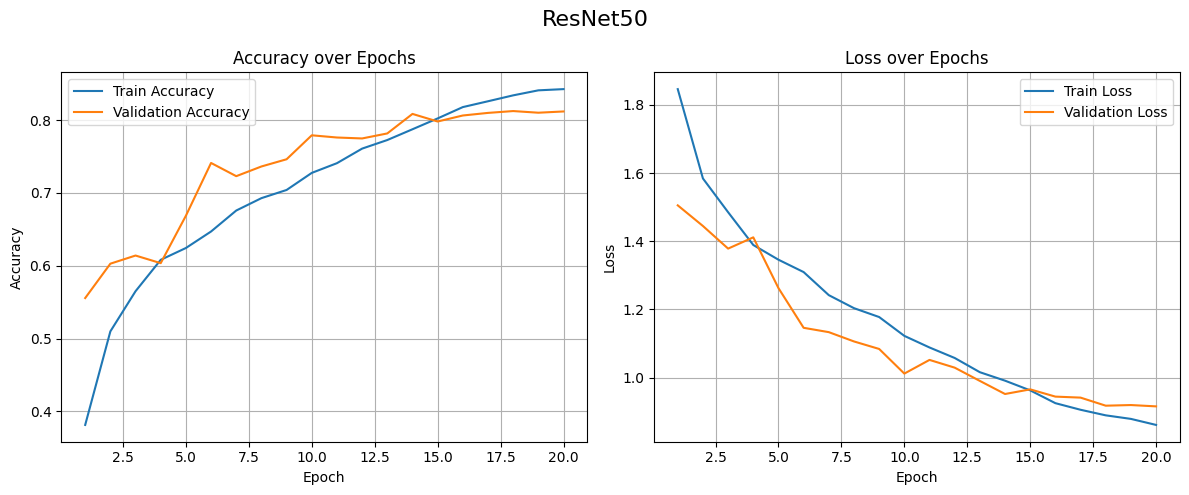

In [ ]:
plot_history(history_resnet50, 'ResNet50')


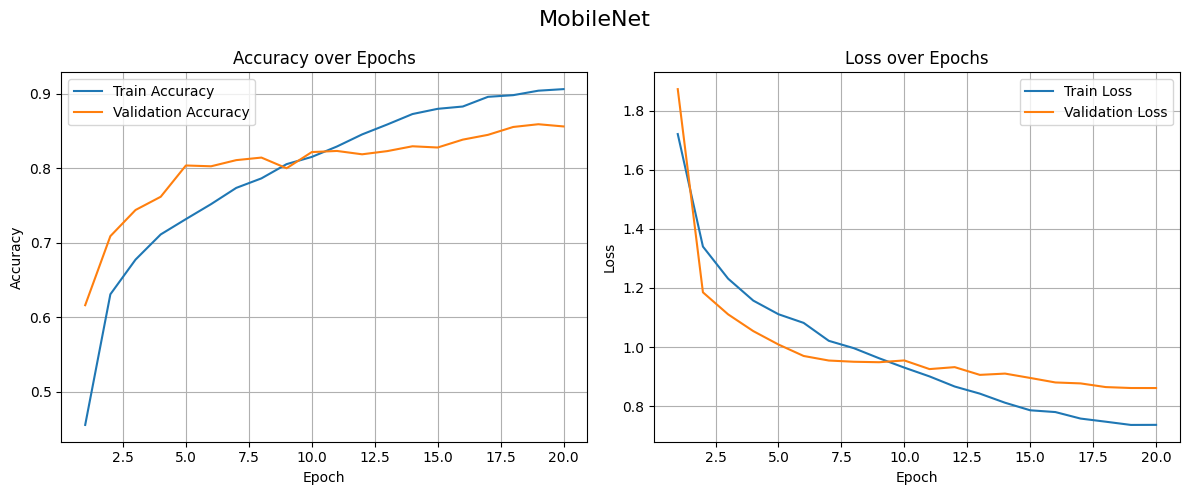

In [ ]:
plot_history(history_mobileNet, 'MobileNet')